In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.fakeflares import aflare

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import pytest

from funcs.model import daylength, on_off, model, lambert, dot_ensemble

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Plots 

(900,)
300


array([1.55454671, 1.55815774, 1.56176876])

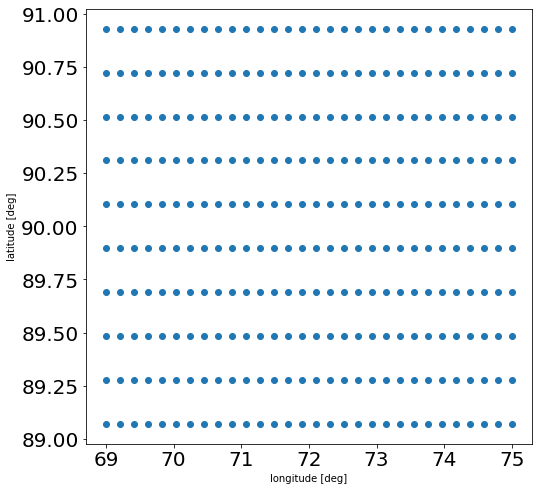

In [2]:
# plot a grid

#latitudes, longitudes = dot_ensemble(np.pi/2-np.pi/8,np.pi/2-np.pi/10,4,num_pts=1e6)
latitudes, longitudes = dot_ensemble(90/180*np.pi,np.pi/2-np.pi/10,1,num_pts=1e6)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
#plt.scatter([180/2-180/10],[180/2-180/8],)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]")
#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)
latitudes[:3]

In [ ]:
# Plot a model consisting of an ensemble of rotating flaring points on a sphere

I = 71 * np.pi / 180.
phi = np.linspace(0,6*np.pi,2000)
flares = []
#for i in np.linspace(2.5,3.5,20):
#    flares.append( aflare(phi, i, 2.44, 5,))
flare = aflare(phi, 2.4, 4.2, 15,)

lamb, onoff, m = model(phi, latitudes, longitudes, flare, I)

plt.figure(figsize=(10,4))
#for l,oo in zip(lamb,onoff):
#    plt.plot(phi/2/np.pi, l*oo*flare, alpha=.1, c="grey")
#for f in flares:
#    lamb, onoff, m = model(phi, latitudes, longitudes, f, I)
#    plt.plot(phi/2/np.pi,m+1,c="k",linewidth=.1,)# label="model light curve")#,\naverage of individual\ngrid dots (in grey)")
plt.plot(phi/2/np.pi,m+1,c="k",linewidth=4, label="model light curve")#,\naverage of individual\ngrid dots (in grey)")

plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="r",linestyle="dashed",linewidth=4)
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
#plt.yscale("log")
plt.tight_layout()
#plt.ylim(0,6)
#plt.savefig(f"{CWD}/analysis/plots/ddt/lightcurve_l70_i71_linear2.png",dpi=300);